In [1]:
import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import functions as f

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression


# Project Description

# Project Goal
* Discover drivers of outcome
* Use drivers of outcomes to develop machine learning models to predict outcomes

# Initial Thoughts

* Our initial hypothesis is that the drivers of outcome will be breed, age, condition, species, and sex.

## Acquire
* The data was aquired on `10 July 2023`
* Two datasets downloaded from data.austintexas.gov: [Intake Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) & [Outcome Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
* Intake Dataset: 153,077 rows and 12 columns 
* Outcome Dataset: 153,449 row and 12 columns
* Each row represents an animal's case
* Each column represents features of the animal

## Prepare
- Two dataframes were created, model_df with encoded variables
- Altered column names for readability, and convenience
- Dropped nulls, duplicate ids, species other than cats and dogs
- Converted data types of various columns to appropriate ones such as 'dates' from string to datetime
- Columns were renamed
- Added Features: sex, breed, condition, outcome_age, rel_month, rel_year, primary_color, is_tabby, mix_color 
- Removed Features: id, name_x, monthyear_x, animal type_x, sex upon intake, age upon outcome, breed_x, color_x, monthyear_y, found location, age upon intake, outcome subtype, intake_datetime, outcome_datetime, outcome_date, intake_date
- Split data into train, validate and test (approx. 60/20/20), stratifying on 'outcome'
- Outliers were not adressed as they were part of the target


In [60]:
# acquire df
df = pd.read_csv('merged_data.csv')

In [61]:
#pulling in prepare function from functions.py, creating two dataframes, "df" and "model_df"
df, model_df = w.prep_df(df)

# pre exploration split: train, validate test
train, validate, test = w.split_data(df, 'outcome')

train -> (66047, 14), 60.0%
validate -> (22016, 14),20.0%
test -> (22016, 14), 20.0%


### Sneak Peak at the Data


In [4]:
# overview of data
train.head()

,dob,outcome,sex,name,intake_type,condition,species,breed,outcome_age,rel_month,rel_year,primary_color,is_tabby,mix_color
163069,2021-09-23,adoption,spayed female,1,owner surrender,normal,cat,mix,74,dec,2021,brown,1,0
1996,2019-06-08,adoption,spayed female,1,stray,sick,cat,single breed,760,jul,2021,tricolor,0,1
106857,2015-04-23,adoption,spayed female,1,stray,normal,cat,mix,66,jun,2015,orange,1,0
100979,2021-10-16,adoption,intact male,1,public assist,normal,dog,mix,552,apr,2023,black,0,1
148660,2021-04-09,adoption,neutered male,1,owner surrender,normal,cat,mix,100,jul,2021,orange,1,0


# Exploration

* Confidence Interval: 95%

### Exploratory Questions: 
- Is Month Related to Outcome?
- Is Breed Related to Outcome?
- Is Sex Related to Outcome?
- Is Species Related to Outcome?

### Q 1. Is Month Related to Outcome?

* $Ho$ = There is no relationship between month and outcome.
* $Ha$ = There is a relationship between month and outcome.

In [19]:
f.month_viz(train)

In [6]:
f.month_stats(train)

,Chi-square statistic,p-value,Degrees of freedom
0,610.319178,5.899323e-115,22


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of overall outcomes that occurred in June, July, August, and December
    * Mixed breeds are far more likely to be adopted
* Mixed breeds are more likely to be transfered or adopted


*Based on the result of our test and the observations in the chart, we can infer that animal breed  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 2. Is Breed Related to Outcome?

* $Ho$ = There is no relationship between breed and outcome.
* $Ha$ = There is a relationship between breed and outcome.

In [7]:
f.breed_viz(train)

In [8]:
f.breed_stats(train)

,Chi-square statistic,p-value,Degrees of freedom
0,254.219044,8.028188e-54,4


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of mixed breeds that are not adopted or transfered
* Mixed breeds are more likely to be transfered or adopted

*Based on the result of our test and the observations in the chart, we can infer that animal breed  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 3  Is Sex Related to Outcome?

* $Ho$ = There is no relationship between sex and outcome.
* $Ha$ = There is a relationship between sex and outcome.

In [9]:
f.sex_viz(train)

In [10]:
f.sex_stats(train)

,Chi-square statistic,p-value,Degrees of freedom
0,23203.389723,0.0,6


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small.

####  Observations: 
* We can clealy observe a difference in outcomes between intact and fixed animals
    * Fixed animals are far more likely to be adopted
    * This is likly due to the common policy of animal rescues fixing animals before adoption
* Intact males are slightly more likely to have an ‘other’ outcome than intact females
* Intact females are slightly more likely to be transfered than intact males

*Based on the result of our test and the observations in the chart, we can infer that animal sex  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q4.  Is Species Related to Outcome?

* $Ho$ = There is no relationship between species and outcome.
* $Ha$ = There is a relationship between species and outcome.

In [11]:
f.species_viz(train)

In [12]:
f.species_stats(train)

,Chi-square statistic,p-value,Degrees of freedom
0,1471.743206,0.0,2


The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Among dogs a higher percentage were adopted compared to cats
29289 cats, 36758 dogs
    * ~55% of cats were adopted vs ~70% of dogs, while cats more likely to be transfered ~39% for cats, ~27% for dogs
* Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs

*Based on the result of our test and the observations in the chart, we can infer that species type has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q5. Is Condition Related to Outcome?
* $Ho$ = There is no relationship between condition and outcome.
* $Ha$ = There is a relationship between condition and outcome.

In [13]:
f.condition_stats(train)

,Chi-square statistic,p-value,Degrees of freedom
0,6920.583198,0.0,10


In [14]:
f.condition_viz(train)

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Cats and dogs requiring medical attention or sick are more likely to be transferred - possibly due to outsourcing for medical needs
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that species type has some correlation to their final outcome. Therefore, we will use this feature in our model.

In [ ]:
### Q6 a. Are Male Dogs Adopted More than Female Dogs?
### Q6 b. Are Male Cats Adopted More than Female Cats?
* $Ho$ = There is no relationship between condition and outcome.
* $Ha$ = There is a relationship between condition and outcome.

In [62]:
# Using numpy.where() to apply the transformation
train['adopted'] = np.where(train['outcome'] == 'adoption', 1, 0)

In [93]:
dog_mask = train[train.species == "dog"]
cat_mask = train[train.species == "cat"]

In [94]:
# dog and cats adopted 
adopted_dog = dog_mask[dog_mask.adopted == 1]
adopted_cat = cat_mask[cat_mask.adopted == 1]

In [95]:
# dogs and cats not adopted 
unadopted_dog = dog_mask[dog_mask.adopted == 0]
unadopted_cat = cat_mask[cat_mask.adopted == 0]

In [101]:
cat_mask['is_female'] = np.where(cat_mask['sex'].str.contains('female', case=False), 1, 0)

In [103]:
cat_mask.is_female.value_counts()

1    14905
0    14384
Name: is_female, dtype: int64

<AxesSubplot:>

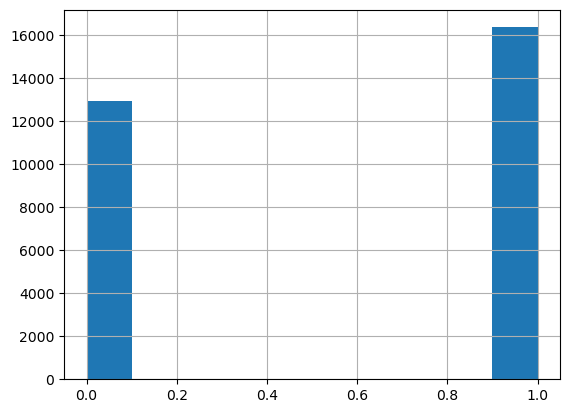

In [106]:
cat_mask.adopted.hist()

## Exploration Summary


# Continuing to Modeling
- Identifed features that have a significant relationship with outcome:
    * June, July, August, and December had higher volumes
    * Mixed breeds are more likely to be transfered or adopted
    * Fixed animals are far more likely to be adopted
    * Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs
    * Cats and dogs with normal conditions are more likely to be adopted.
    
- Month of outcome, Breed of species, Sex, Species, Condition, Mix_color, Month_Rel:
    * Each feature had a statistically significant relaitonship with outcome
    
# We did not move forward with the following features: 
* Year_rel: Showed overall trend and would not be a accurate prediction
* Outcome_age: Data integrity issued was raised when we found negative ages
      

## Modeling

- Evaluation Meteric: Accuracy
- Target is outcome
- Baseline: 63.3% (adopted)
- Models will be developed using a few different types, various features, and various hyperparameter configurations
    - KNN
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Support Vector Machine
- Models will be evaluated on Train and Validate
- Best performing model will only be evaluated on Test

In [15]:
# get x and y variables
x_train,y_train,x_validate,y_validate,x_test,y_test = f.get_xy(model_df)

train -> (66047, 34), 60.0%
validate -> (22016, 34),20.0%
test -> (22016, 34), 20.0%


In [16]:
# get models - train and validate scores
f.get_models(x_train,y_train,x_validate,y_validate)

,model,set,accuracy
0,k_nearest_neighbors,train,0.790800
1,k_nearest_neighbors,validate,0.789835
2,logistic_regression,train,0.794586
3,logistic_regression,validate,0.796012
4,DecisionTreeClassifier,train,0.790619
5,DecisionTreeClassifier,validate,0.791788
6,random_forest,train,0.712296
7,random_forest,validate,0.713118
8,support_vector_machine,train,0.798689
9,support_vector_machine,validate,0.797829


# Comparing Models
Baseline: 63.87
* The KNN Model yielded a train accuracy of 79.08 and a validate accuracy of 78.99
* The Logistics Regression Model yielded a train accuracy of 79.46 and a validate accuracy of 79.60
* The Decision Tree Model yielded a train accuracy of 79.06 and a validate accuracy of 79.18
* The Random Forest Model yielded a train accuracy of 71.23 and a validate accuracy of 71.31
* The Support Vector Machine Model yielded a train accuracy of 79.87 and a validate accuracy of 79.78
* The Naive Bayes Model yielded a train accuracy of 67.73 and a validate accuracy of 67.66
* The Gradient Boosting Model yielded a train accuracy of 79.74 and a validate accuracy of 79.76

# Model Selection
* The Gradient Boosting Model maintained a 79.75 % average accuracy with only a 0.02 differential in both train and validate. While most of the models did well with the exception of the Naive Bayes model, there were slight variances between the train and validate sets. We beat the baseline accuracy score of 63.87% by 15.88% when using the average of the Gradient Boosting Model. We will move forward with the Gradient Boosting Model using the final test data set.

In [17]:
f.run_gradient_boost(x_train, y_train, x_test, y_test)

,model,set,accuracy,recall,precision
0,gradient_boosting,test,0.798919,0.798919,0.788586


# Model Summary
* The Gradient Boost model had a test accuracy score of 79.8%, which is approximately 16% greater than the baseline. 

## Report - Summary
 
### Recommendations
* During the high adoptions months promote cats, mixed breeds, more by reducing adoption costs, adding stories and character traits.


* Provide additional takeaways or downloadable docs for extensively used topics
* We have data governance recommendations:
    - We found tens of thousands of rows with data that was missing and/or had nonsensical information
    * Collect information more information such as: 
        - Incidents (e.g. biting, abuse hx) 
        - Stated reason for return 
        - Reasons for turn in by owners
        - Vaccination status
        - Who turned the animal in (e.g. citizen, law enforcement, organization)
        - Microchipped

### Next Steps
* If provided more time we would use NLP to review the polarity of the names. 
* Review other shelters with different features